# Recurrent Neural Networks
These are NNs which work with sequences of data and have an element of time.<br>
The interesting thing about them is that they have a memory component,
so you can prioritise more recent (or earlier if  you wish) data when training
a model.<br>
_Example: The more recent prices of a stock are likely to be more relevant when attempting to predict the next price._
<p>

In [21]:
# Imports

import numpy as np
import numpy.random as rnd
import itertools
import os
import sys
import scipy.misc
import random
import time

# We will use some utilities from sklearn
from sklearn.preprocessing import StandardScaler

# PyTorch
import torch
from torch import nn
from torch.optim import Adam, SGD
from torchsummary import summary
from torch.autograd  import Variable

# Used for plotting and display of figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


from IPython.display import display, clear_output
from IPython.display import Image
from IPython.display import SVG

print("Imports complete")

Imports complete


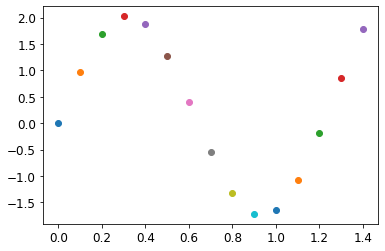

KeyboardInterrupt: 

In [37]:
# The function below, given a value, generates some result
# If we give it a series of values, it will generate a series of results.
def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)


# Just a list of 0.1, 0.2, 0.3...
a_range = range(0,50)
some_times = []
for step in a_range:
    some_times.append(step / 10)
points = []

# Run this cell and take a look at the updating graph, a pattern begins to form
for a_time in some_times:
    #print(time_series(time))
    clear_output()
    points.append([a_time, time_series(a_time)])
    for x, y in points:
        plt.scatter(x,y)
    plt.show()
    # Time as in make the program wait, bad choice I know
    time.sleep(0.5)

In [39]:
"""

We train these types of networks with sequences of data, be it price info, a list of pixels, whatever.
From a time series, we would extract some sequences (at random) from it of some length (κ), these are our samples.

The below function does just that...
 """

# This just generates some random data
t_min, t_max = 0, 30
resolution = 0.1

# Receives the number of samples (batch_size) of size (n_steps) to extract
# from the time series, and outputs such a sample

# batch_size is how many samples
# n_steps is the length of the sequence (our κ)
def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)


next_batch(5, 3)

(array([[[ 0.24227129],
         [ 2.02285132],
         [ 3.53798791]],
 
        [[-5.6249364 ],
         [-5.80014216],
         [-5.68019731]],
 
        [[-4.8425182 ],
         [-4.36902945],
         [-4.30624516]],
 
        [[-1.55026718],
         [-2.26498206],
         [-2.62768353]],
 
        [[-3.71989627],
         [-4.85757551],
         [-6.04931194]]]),
 array([[[ 2.02285132],
         [ 3.53798791],
         [ 4.61319196]],
 
        [[-5.80014216],
         [-5.68019731],
         [-5.48839383]],
 
        [[-4.36902945],
         [-4.30624516],
         [-4.54931696]],
 
        [[-2.26498206],
         [-2.62768353],
         [-2.51080253]],
 
        [[-4.85757551],
         [-6.04931194],
         [-7.05030071]]]))

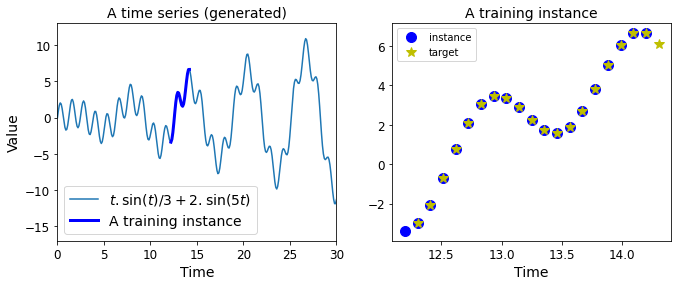

In [40]:
#In the next cell, we visualize the time series, and an example of training pairs $(x,y)$,
# where $x$ is a sequence of $k=20$ points and $y$ is the target sequence of $20$ points,
# the ones obtained by shifting $x$ only one position.
"""
Let's visualise again.
Here we will use a 20-item sequence and from it attempt to produce another 20-item sequence.


Input = x = a sample
Output = y = a target, here it is a similar sample to x, but shifted along by 1 reading
e.g. if...
x = [2,4,6,8,10]
y would be = [4,6,8,10,12]


Below is a nice plot, thanks Jon
From a generated time series,
We take a sequence of data (x)
and can build a target (y)

Now we have a training instance (x,y),
Do that a bunch of times to build a training set
"""


# The time series and the example of (x,y) are shown

t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "y*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


#save_fig("time_series_plot")
plt.show()

Index(['date', 'ISE', 'ISE.1', 'SP', 'DAX', 'FTSE', 'NIKKEI', 'BOVESPA', 'EU',
       'EM'],
      dtype='object')


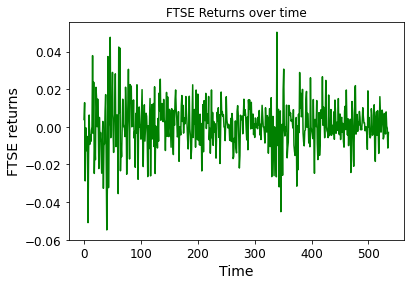

Nothing immediately jumps out as a pattern


,date,ISE,ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
0,5-Jan-09,0.035754,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524
1,6-Jan-09,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773
2,7-Jan-09,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
3,8-Jan-09,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
4,9-Jan-09,0.009860,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802


In [68]:
# Load in some sample data, it's some stock prices
import pandas as pd
import seaborn as sns

# I'll plot the FTSE
df = pd.read_csv('data_akbilgic.csv')
print(df.columns)
plt.title(("FTSE Returns over time"))
plt.plot(df['FTSE'], color="green")
plt.xlabel("Time")
plt.ylabel("FTSE returns")
plt.show()
print("Nothing immediately jumps out as a pattern")
df.head()

In [100]:
# Let's prepare some data to train!
df_size = df.shape[0] # How many data points we have
df_train = 0
df_test = 0

# In order to train a model, we'll first need to build some data to train with
# Similar to above, we will take sequences of data of a certain length
def next_stock_batch(batch_size, n_steps, df_base):
    t_min = 0
    # We can't sample non-existent data
    t_max = df_base.shape[0]

    # The inputs will be formed by 8 sequences taken from
    # 7 time series [ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU]
    x = np.zeros((batch_size,n_steps,7))
    print(f"x.shape: {x.shape}")

    # We want to predict the returns of the Istambul stock (ISE.1)
    # taken into consideration the previous n_steps days
    y = np.zeros((batch_size,n_steps,1))
    print(f"y.shape: {y.shape}")

    # We chose batch_size random points from time series x-axis
    starting_points = np.random.randint(0,t_max-n_steps-1,size=batch_size)
    print(starting_points)

    input_cols = ["ISE.1","SP","DAX","FTSE","NIKKEI","BOVESPA","EU"]
    #for start in starting_points:
        # We create the batches for x using all time series (8) between t and t+n_steps
    # print("#####")
    # for sample in x:
    #     for row in sample:
    #         pass
    # print("#####")

    # This is awful, but I think it builds x and y

    # For each of the starting points,
    for sample_no, start in enumerate(starting_points):
        #print(sample_no)
        # We want to grab data from an exchange
        for seq_no, exchange in enumerate(input_cols):
            #print(">",seq_no)
            one_sequence = df_base[exchange][start:start+n_steps]
            #print(one_sequence.shape)
            # And put it in the correct locations in x
            for index, data_point in enumerate(one_sequence):
                #print(">>",index)
                x[sample_no][index][seq_no] = data_point

            y[sample_no][seq_no] = df_base[exchange][start+n_steps+1]

    # We create the batches for y using only one time series between t+1 and t+n_steps+1

    #Save on x and y the time series data sequence and the prediction sequence

    return x,y

# Output is big
# next_stock_batch(5,10,df)

In [101]:
"""
Next up we will define some parameters for our network
"""
# An RNN can take as inputs multiple input sequences (e.g, a matrix of n_seq x n_steps)
# Since we use only a single TS, n_inputs=1

# We are using 7 different exchanges here so...
n_inputs = 7

# This is the size of each sequence, 10 is a nice number to start with
n_steps = 10

# There is one layer of X recurrent neurons together
n_neurons = 10

# The ouput will be a single sequence
n_outputs = 1

In [103]:
# Architecture time

# This is a default pytorch architecture
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, n_steps):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.hidden = [0]
        #Defining the layers
        # RNN Layer

        self.rnn = nn.RNN(input_size, n_outputs, n_layers, batch_first=True)

    def forward(self, x):

        # complete the forward function so it returns the output and the last hidden state
        # what is the input of an RNN?
        if len(self.hidden) == 1:
            #inicitialize at 0 values
            return out, hidden

    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        return hidden

In [109]:
# Optimiser and Loss functions

# We initialize our RNN model to pass it to the optimizer
model = Model(input_size=n_inputs, output_size=n_outputs, n_steps=n_steps, hidden_dim=n_neurons, n_layers=1)

# What would be an adecuate loss function?
criterion =  nn.MSELoss # Criterion == Loss == Cost

# optimizer to apply the gradients
optim = SGD(model.parameters(), lr=0.01, momentum=0.9)

In [114]:
## Trainning Loop

#We will define the training loop for our model.
# This training loop is a little different than the usual.
# A normal training loop is epoch based meaning that it trains for a
# certain ammount of epochs seeing the whole dataset in each epoch.
# For this model we will use an 'online' training which mean we will generate
# the batches the moment before feeding it with no real regard for running trhough the entire dataset.


#number of batches we will go through
n_iterations = 500
#how many squence there will be in a bacth
batch_size = 25
#after how many operations we will print information
printing_gap = 100

#We will store the loss values here to plot them
train_loss = []


train_loss = []
for iter in range(n_iterations):
    #Get a batch
    x_batch, y_batch = next_stock_batch(batch_size, n_steps, df)
    #make into tensor
    x_batch = torch.from_numpy(x_batch)
    y_batch = torch.from_numpy(y_batch)
    #make them into torch variables in float format
    x_batch = Variable(x_batch).float()
    y_batch = Variable(y_batch).float()
    #Reset the gradients
    optim.zero_grad()
    #Get the outputs
    output = model(x_batch)

     #compute the loss
    loss = criterion(output, y_batch.flatten())
   #compute the gradients
    loss.backwards()
      #Apply the gradients
    optim.step()


    #Append the loss value
    train_loss.append(loss.item())

    if iter % printing_gap == 0:
        #Print the information
        print(f"Iteration {iter} - Loss: {loss}")


plt.plot(train_loss, label= "Train Loss")
plt.xlabel(" Iteration ")
plt.ylabel("Loss value")
plt.legend(loc="upper left")
plt.show()




# ToDo :Understand this concept
#       Make model work
#       Training
#       Testing
#       Visualisations
#       Extra Exercises

x.shape: (25, 10, 7)
y.shape: (25, 10, 1)
[118  99 442 243 136 204 312 101 333 487 373  67 398  43   7 337 523  83
  76  79 223 430 235 130 523]


NameError: name 'out' is not defined